# Comparing students' bets against a pragmatic listener model
Natalia Vélez, February 2022

In [1]:
%matplotlib inline
import os,sys
import pandas as pd
import numpy as np
from ast import literal_eval
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import distance
from os.path import join as opj
import rsatoolbox
from scipy.stats import spearmanr, ttest_rel

sys.path.append('..')
from utils import int_extract, read_json

sys.path.append('../2_behavioral/')
import teaching_models as teach

sns.set_style('white')
sns.set_context('talk')

Loading teaching problems
{'A': [[0, 0, 1, 1, 0, 0],
       [0, 1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 0],
       [0, 0, 1, 1, 0, 0]],
 'B': [[1, 1, 1, 0, 0, 0],
       [1, 1, 1, 0, 0, 0],
       [1, 1, 1, 1, 0, 0],
       [0, 0, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]],
 'C': [[0, 0, 0, 1, 1, 1],
       [0, 0, 0, 1, 1, 1],
       [0, 0, 1, 1, 1, 1],
       [0, 0, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]],
 'D': [[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 0, 0],
       [1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1]]}
Participants excluded from analysis:
[3, 17]
Cleaning up human behavioral data
    subject  run  block_idx  ex_idx first_movement   start  problem  \
0         1    1          0       0         [0, 1]  [0, 0]       22   
1         1    1          0       1         [0, 1]  [0, 0]       22   
3         1    1          1   

Load student data:

In [2]:
student_df = pd.read_csv('outputs/student_behavior.csv')
student_df['num_hint'] = (student_df['num_hint'] + 1).astype(int)
student_df['problem'] = student_df['problem'].astype(int)
student_df['teacher'] = student_df.teacher.apply(lambda s: int_extract('(?<=sub-)[0-9]+', s))
student_df['bets'] = student_df.bets.apply(literal_eval)
student_df['student'] = student_df.worker.factorize()[0]+1
student_df = student_df.drop(columns=['worker'])

student_df = student_df.rename(columns={'order': 'trial_order'})

print('Loaded data from %i/140 students' % student_df.student.nunique())
student_df.head()

Loaded data from 140/140 students


,time_elapsed,teacher,problem,num_trial,num_hint,bets,bonus,trial_order,batch,student
0,181304,4,34,0.0,1,"[0, 35, 41, 48]",0.013777,0,2022-02-02-1303,1
1,192911,4,34,0.0,2,"[0, 50, 49, 0]",0.020623,0,2022-02-02-1303,1
2,203582,4,34,0.0,3,"[0, 0, 100, 0]",0.041667,0,2022-02-02-1303,1
3,223655,27,15,1.0,1,"[0, 52, 50, 48]",0.014444,0,2022-02-02-1303,1
4,232054,27,15,1.0,2,"[0, 52, 50, 0]",0.021242,0,2022-02-02-1303,1


Merge with teacher examples:

In [3]:
# Behavioral data
teacher_examples = (
    teach.human_df
    .copy()
    .rename(columns={'subject': 'teacher'})
)
teacher_examples['dummy'] = 1
teacher_examples.head()

# replace ex_idx with cumulative index
teacher_examples['order'] = teacher_examples.order.apply(literal_eval)
teacher_examples['num_hint'] = teacher_examples.groupby(['teacher', 'problem'])['dummy'].cumsum()
teacher_examples = teacher_examples[['teacher', 'problem', 'order', 'num_hint', 'example']]
teacher_examples.head()

,teacher,problem,order,num_hint,example
0,1,22,"[C, B, D, A]",1,8
1,1,22,"[C, B, D, A]",2,27
3,1,18,"[D, B, C, A]",1,3
4,1,18,"[D, B, C, A]",2,32
5,1,18,"[D, B, C, A]",3,7


Merge with student data:

In [4]:
def normalize_bets(row):
    '''
    Helper function to ensure that bets add up to 1
    '''
    bets_norm = np.array(row.bets)/np.sum(row.bets)
    bets_sorted = [b for _, b in sorted(zip(row.order, bets_norm))]
    
    return bets_sorted

labels = ['A', 'B', 'C', 'D']

# merge data
student_bets = student_df.merge(teacher_examples).rename(columns={'num_hint': 't'})
student_bets = student_bets.sort_values(by=['batch', 'student', 'time_elapsed']).reset_index(drop=True)

# order bets and split into columns
student_bets['bets_norm'] = student_bets.apply(normalize_bets, axis=1)
student_bets[labels] = student_bets['bets_norm'].apply(pd.Series)

# clean up dataframe
id_vars = ['student', 'problem', 'teacher', 't']
student_bets = student_bets[id_vars + labels]
student_bets = pd.melt(student_bets, id_vars=id_vars, value_vars=labels, var_name='hypothesis', value_name='bet')
student_bets = student_bets.sort_values(by=['student', 'problem', 't']).reset_index(drop=True)
student_bets.head()

,student,problem,teacher,t,hypothesis,bet
0,1,0,15,1,A,0.433566
1,1,0,15,1,B,0.566434
2,1,0,15,1,C,0.000000
3,1,0,15,1,D,0.000000
4,1,0,15,2,A,1.000000


## Plot student bets

In [34]:
def plot_problem(prob_idx):
    problem = teach.problems[prob_idx]
    labels = list(problem.keys())
    prob_arr = np.array(list(problem.values()))
    
    fig,axes=plt.subplots(1,prob_arr.shape[0], figsize=(12,3))
    for i,arr in enumerate(prob_arr):
        sns.heatmap(arr, square=True, cmap='Greys', cbar=False, ax=axes[i], lw=1, linecolor='#aaa')
        axes[i].set(xticklabels=[], yticklabels=[], title=labels[i])

    return fig

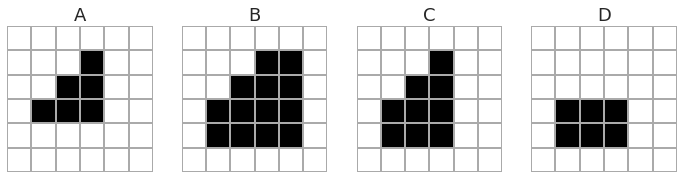

In [40]:
fig=plot_problem(20)

In [5]:
def plot_bets(prob, teacher):
    prob_bets = student_bets[(student_bets.problem == prob) & (student_bets.teacher == teacher)]

    g = sns.catplot(data=prob_bets, x='hypothesis', y='bet', col='t', hue='student', 
                    kind='bar', legend=False, palette='Set2', aspect=.8)
    g.set_axis_labels('Hypothesis', 'Posterior belief')
    g.fig.suptitle(f'Teacher {teacher}, Problem {prob}', y=1.05)
    return g

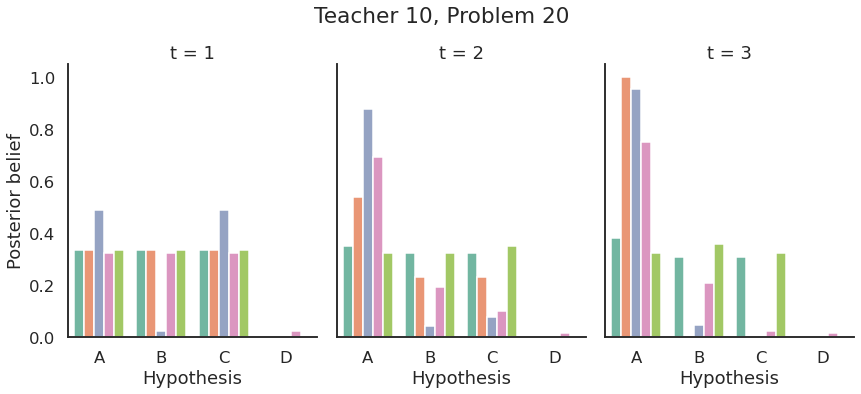

In [52]:
plot_bets(20, 10)

Pedagogical model predictions:

In [53]:
def pragmatic_beliefs(prob, teacher):

    prob_ex = teacher_examples[(teacher_examples.problem == prob) & (teacher_examples.teacher == teacher)]

    belief_list = []
    pH = None
    past_examples = []

    # get model predictions at each timestep
    for _,row in prob_ex.iterrows():
        _, pH = teach.pedagogical_sampling(prob,past_examples=past_examples,last_pH=pH)
        past_examples.append(row.example)
        belief_list.append(pH.loc[row.example])    
    belief_df = pd.DataFrame(belief_list).fillna(0)

    # save to dataframe
    belief_df['t'] = prob_ex['num_hint'].values
    belief_df['problem'] = prob
    belief_df['teacher'] = teacher
    belief_df['model'] = 'pragmatic'
    belief_df = (
        belief_df
        .melt(id_vars=['model', 'teacher', 'problem', 't'], value_vars=labels, 
              var_name='hypothesis', value_name='posterior')
        .sort_values(by=['teacher', 'problem', 't', 'hypothesis'])
        .reset_index(drop=True)
    )
    
    return belief_df

Literal model predictions:

In [54]:
def literal_beliefs(prob, teacher):

    prob_ex = teacher_examples[(teacher_examples.problem == prob) & (teacher_examples.teacher == teacher)]

    belief_list = []
    past_examples = []

    # get model predictions at each timestep
    for _, row in prob_ex.iterrows():
        pH = teach.filter_consistent_examples(prob, past_examples=past_examples)
        pH = pH.div(pH.sum(axis=1), axis=0)
        past_examples.append(row.example)
        belief_list.append(pH.loc[row.example])    

    belief_df = pd.DataFrame(belief_list).fillna(0)

    # save to dataframe
    belief_df['t'] = prob_ex['num_hint'].values
    belief_df['problem'] = prob
    belief_df['teacher'] = teacher
    belief_df['model'] = 'literal'
    belief_df = (
        belief_df
        .melt(id_vars=['model', 'teacher', 'problem', 't'], value_vars=labels, 
              var_name='hypothesis', value_name='posterior')
        .sort_values(by=['teacher', 'problem', 't', 'hypothesis'])
        .reset_index(drop=True)
    )
    
    return belief_df

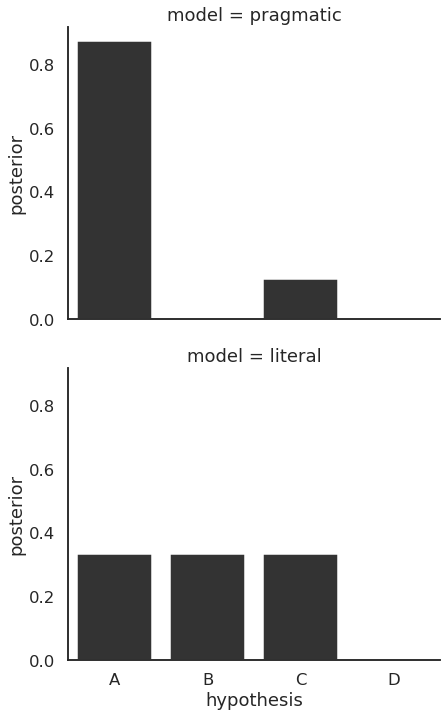

In [56]:
prag = pragmatic_beliefs(20, 10)
lit = literal_beliefs(20, 10)
model_test = pd.concat([prag,lit])
model_test = model_test[model_test.t == 3]

g = sns.catplot(data=model_test, row='model', x='hypothesis', y='posterior', kind='bar', color='#333', aspect=1.25)

 ## Make RDMs

### 1) Behavioral RDM

In [ ]:
def student_rdm(stud):
    # initialize output
    rdm = np.zeros((40,40))

    # split dataframe by timepoint
    in_df = stud.copy()
    in_df['group_id'] = in_df.groupby(['problem', 't']).ngroup()
    n_groups = in_df.group_id.nunique()

    # compare belief distributions at each timepoint
    rdm = np.zeros((n_groups, n_groups))
    for gi in range(n_groups):
        gi_belief = in_df[in_df.group_id == gi].bet
        for gj in range(gi+1, n_groups):
            # compute cosine distances
            gj_belief = in_df[in_df.group_id == gj].bet
            gi_gj = distance.cosine(gi_belief, gj_belief)

            # save to rdm
            rdm[gi,gj] = gi_gj
            rdm[gj,gi] = gi_gj
    return rdm

### 2) Model-based RDMs

Make dataframe of all model predictions:

In [ ]:
model_list = []
for (problem, teacher), _ in student_bets.groupby(['problem', 'teacher']):
    prag = pragmatic_beliefs(problem, teacher)
    lit = literal_beliefs(problem, teacher)
    model_list.append(prag)
    model_list.append(lit)

model_df = pd.concat(model_list)
print(model_df.shape)
model_df.head()

Save model predictions to file to save some time

In [ ]:
model_df.to_csv('outputs/model_posteriors.csv', index=False)

Use model predictions to make a participant-specific RDM:

In [ ]:
 def model_rdm(stud, model):
    model_in = model_df[model_df.model == model].copy()

    # split human data by timepoint
    human_df = stud.copy()
    human_df['group_id'] = human_df.groupby(['problem', 't']).ngroup()
    n_groups = human_df.group_id.nunique()
    in_df = human_df.merge(model_in)
    
    # initialize rdms
    model_rdm = np.zeros((n_groups,n_groups))

    # compare belief distributions at each timepoint
    for gi in range(n_groups):
        gi_belief = in_df[in_df.group_id == gi].posterior
        for gj in range(gi+1, n_groups):
            # compute cosine distances
            gj_belief = in_df[in_df.group_id == gj].posterior
            gi_gj = distance.cosine(gi_belief, gj_belief)

            # save to rdm
            model_rdm[gi,gj] = gi_gj
            model_rdm[gj,gi] = gi_gj
            
    return model_rdm

Plot RDMs for a single participant:

In [ ]:
def plot_rdms(behav_rdm, prag_rdm, lit_rdm):
    fig,axes=plt.subplots(1,3,figsize=(15,4))
    sns.heatmap(behav_rdm, square=True, ax=axes[0], vmin=0, vmax=1, cmap='magma')
    axes[0].set(xticklabels=[], yticklabels=[], title='Data')

    sns.heatmap(prag_rdm, square=True, ax=axes[1], vmin=0, vmax=1, cmap='magma')
    axes[1].set(xticklabels=[], yticklabels=[], title='Pragmatic student')

    sns.heatmap(lit_rdm, square=True, ax=axes[2], vmin=0, vmax=1, cmap='magma')
    axes[2].set(xticklabels=[], yticklabels=[], title='Literal student')
    
    return fig

Main loop: Make RDMs for all participants

In [ ]:
out_dir = 'outputs/rdm'
os.makedirs(out_dir, exist_ok=True)
corr_list = []

for student,group in student_bets.groupby('student'):
    behav_mtx = student_rdm(group)
    prag_mtx = model_rdm(group, 'pragmatic')
    lit_mtx = model_rdm(group, 'literal')

    # Compare RDMs
    tri=np.tril_indices(behav_mtx.shape[0],-1)
    vs_prag = spearmanr(behav_mtx[tri], prag_mtx[tri]).correlation
    vs_lit = spearmanr(behav_mtx[tri], lit_mtx[tri]).correlation
    corr_list.append((student, vs_prag, vs_lit))

    # Save RDMs
    np.save(f'outputs/rdm/student-{student:03d}_rdm.npy', np.array([behav_mtx, prag_mtx, lit_mtx]))
    fig = plot_rdms(behav_mtx, prag_mtx, lit_mtx)
    plt.savefig(f'plots/rdm/student-{student:03d}_rdm.png')
    plt.close()
    
corr_df = pd.DataFrame(corr_list, columns=['student', 'pragmatic', 'literal'])
corr_df.to_csv('outputs/student_rdms.csv', index=False)

Compare similarities to pragmatic, literal student predictions:

In [ ]:
corr_df[['pragmatic_z', 'literal_z']] = np.arctanh(corr_df[['pragmatic', 'literal']])
print(corr_df.shape)
corr_df.head()

In [ ]:
corr_df[['pragmatic', 'literal']].agg('mean')

In [ ]:
ttest_rel(corr_df.pragmatic_z, corr_df.literal_z)